# CIENCIA DE DATOS - INCENDIOS FORESTALES - UTN-FRBA
Barreto, Romina 

Pulella, María Belén

Vigón, Lucila Belén

In [1]:
#Importamos librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/My Drive/Ciencia_de_Datos/

/content/drive/My Drive/Ciencia_de_Datos


In [4]:
#Importamos el primer dataset
df = pd.read_csv('/content/drive/My Drive/Ciencia_de_Datos/incendios-cantidad-causas-provincia.csv',encoding='latin-1',delimiter=";")
 
#Importamos el segundo dataset
df1 = pd.read_csv('/content/drive/My Drive/Ciencia_de_Datos/superficie-incendiada-provincias-tipo-de-vegetacion.csv',encoding='latin-1',delimiter=";")


In [5]:
#Borramos los valores nulos
df=df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df_nulls=df[df.incendio_anio.isnull()]
df=df.loc[0:584]
#Renombramos las columnas para poder formar un unico dataset con df y df1
df=df.rename(columns={'incendio_anio':'year','incendio_provincia':'provincia'})
df1=df1.rename(columns={'superficie_afectada_por_incendios_anio':'year','superficie_afectada_por_incendios_provincia':'provincia'})
df=df.replace({'Ciudad Autónoma de Buenos Aires':'CABA'})
df1=df1.replace({'Ciudad Autónoma de Buenos Aires':'CABA'})
df1=df1.replace({'Ciudad Autónoma de Bs As':'CABA'})
#Formamos el dataset sobre el cual vamos a trabajar
df_df1=pd.merge(df, df1, on=['year','provincia'])
df_df1.fillna(0)
display(df_df1.head(5))
df_df1.shape

,year,provincia,incendio_total_numero,incendio_negligencia_numero,incendio_intencional_numero,incendio_natural_numero,incendio_desconocida_numero,superficie_afectada_por_incendios_total_hectareas,superficie_afectada_por_incendios_bosque_nativo_hectareas,superficie_afectada_por_incendios_bosque_cultivado_hectareas,superficie_afectada_por_incendios_arbustal_hectareas,superficie_afectada_por_incendios_pastizal_hectareas,superficie_afectada_por_incendios_sin_determinar_hectareas
0,1993.0,Buenos Aires,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
1,1993.0,Catamarca,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
2,1993.0,Chaco,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
3,1993.0,Chubut,21.0,18.0,0.0,0.0,3.0,149.5,10.0,6.25,0.0,133.25,0.0
4,1993.0,Córdoba,151.0,0.0,0.0,0.0,151.0,232941.0,59995.0,250.00,0.0,172696.00,0.0


(585, 13)

In [6]:
#Utilizamos los datos de APIs para identificar cada provincia
provincias = pd.read_csv("https://apis.datos.gob.ar/georef/api/provincias?formato=csv")
provincias=provincias.rename(columns={'provincia_nombre':'provincia'})
df_df1=pd.merge(df_df1, provincias, on=['provincia'])

In [7]:
# Aplicamos LabelEncoder a las features categóricas
lbl = LabelEncoder() 
lbl.fit(df_df1['provincia_id'].values) 
df_df1['provincia_id'] = lbl.transform(df_df1['provincia_id'].values)
print('Shape all_data: {}'.format(df_df1.shape))

Shape all_data: (544, 16)


In [8]:
lbl.fit(df_df1['year'].values) 
df_df1['year'] = lbl.transform(df_df1['year'].values)
print('Shape all_data: {}'.format(df_df1.shape))

Shape all_data: (544, 16)


In [9]:
#Creamos nuestra variable dependiente (label - etiqueta) y
y = np.array(df_df1[["incendio_total_numero"]])
#Creamos nuestra variable Independiente X quitando las features que no deseamos
x = np.array(df_df1[["year","provincia_id"]])

Dividimos el dataset en Train Y Test

In [10]:
#Dividimos el dataset en Train Y Test
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.30, random_state=42)
xtrain.shape

(380, 2)

In [11]:
#auto scaling train- set (mean = 0, std = 1)
scaler = preprocessing.StandardScaler().fit(xtrain)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [12]:
# auto scalamos las muestras de train utilizando el scaler fiteado con el xtrain
xtrain_scal = scaler.transform(xtrain)
# auto scalamos las muestras de test utilizando el scaler fiteado con el xtrain
xtest_scal = scaler.transform(xtest)

In [13]:
# Agregamos las features polinomicas LUEGO de escalar los datos
grad_poly = 7
xtrain_poly_scaled = PolynomialFeatures(grad_poly).fit_transform(xtrain_scal)
xtest_poly_scaled = PolynomialFeatures(grad_poly).fit_transform(xtest_scal)

## Modelo de Regresión Lineal

## Linear Features

In [14]:
#Definimos el estimador
est = LinearRegression()
#Definimos diccionario con hyperparametros
parameters = {'fit_intercept' : [False, True]}
#Definimos la cantidad de folds para validar
n_folds = 5
#Definimos el objeto grid search con los parametros anteriores
gs = GridSearchCV(est, param_grid=parameters, cv=n_folds, refit=True, scoring="neg_mean_squared_error")

Sin escalar

In [15]:
#Entrenamos
gs.fit(xtrain, ytrain)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [False, True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [16]:
# Mostramos el mejor estimador, sus hyperparametros seleccionados y su resultado
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 

{'fit_intercept': True} 

-558707.6547028401 



In [17]:
# Usamos x_test para predecir con el mejor estimador
linear_prediction = gs.best_estimator_.predict(xtest)
#Calculamos las metricas R2, MSE y MAE
linear_r2 = r2_score(y_true=ytest, y_pred=linear_prediction)
linear_mse = mean_squared_error(y_true=ytest, y_pred=linear_prediction)
linear_mae = mean_absolute_error(y_true=ytest, y_pred=linear_prediction)

R2 score: 0.000066
MAE: 534.978154
MSE: 1333570.636590


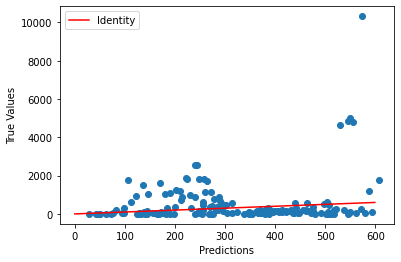

In [18]:
#Vamos a plotear Predictions vs True values
plt.scatter(linear_prediction, ytest)
plt.plot(np.arange(0,600),np.arange(0,600), 'r', label='Identity') #Linea identidad (Predictions = True Values)
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {linear_r2:.6f}')
print(f'MAE: {linear_mae:.6f}')
print(f'MSE: {linear_mse:.6f}')

In [19]:
# creamos un dataframe para guardar los resultados de cada estimador
results_df = pd.DataFrame(columns=['Model','Features','Escalados','R2','MSE','MAE'])
#Guardamos los resultados
results_df = results_df.append({'Model':'Linear',
                                'Features':'Lineal',
                                'Escalados': 'No',
                                'R2':linear_r2,
                                'MSE':linear_mse,
                                'MAE':linear_mae},ignore_index=True)

Escalados

In [20]:
#Entrenamos
gs.fit(xtrain_scal, ytrain)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [False, True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [21]:
# Mostramos el mejor estimador, sus hyperparametros seleccionados y su resultado
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 

{'fit_intercept': True} 

-558707.6547028403 



In [22]:
# Usamos x_test para predecir con el mejor estimador
linear_prediction = gs.best_estimator_.predict(xtest_scal)
#Calculamos las metricas R2, MSE y MAE
linear_r2 = r2_score(y_true=ytest, y_pred=linear_prediction)
linear_mse = mean_squared_error(y_true=ytest, y_pred=linear_prediction)
linear_mae = mean_absolute_error(y_true=ytest, y_pred=linear_prediction)

R2 score: 0.000066
MAE: 534.978154
MSE: 1333570.636590


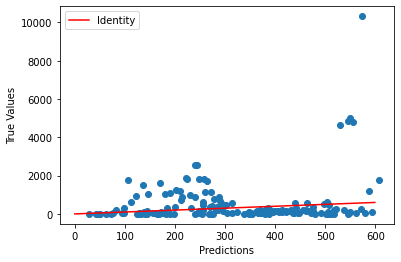

In [23]:
#Vamos a plotear Predictions vs True values
plt.scatter(linear_prediction, ytest)
plt.plot(np.arange(0,600),np.arange(0,600), 'r', label='Identity') #Linea identidad (Predictions = True Values)
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {linear_r2:.6f}')
print(f'MAE: {linear_mae:.6f}')
print(f'MSE: {linear_mse:.6f}')

In [24]:
#Guardamos los resultados
results_df = results_df.append({'Model':'Linear',
                                'Features':'Lineal', 
                                'Escalados': 'Si',
                                'R2':linear_r2,
                                'MSE':linear_mse,
                                'MAE':linear_mae},ignore_index=True)

Polynomial Features

Entrenamos con un set de features polinomicas

In [25]:
#Usamos los mismos parametros para este nuevo GS.
gs = GridSearchCV(est, param_grid=parameters,refit=True, cv=n_folds, scoring="neg_mean_squared_error")
#Entrenamos
gs.fit(xtrain_poly_scaled, ytrain)
# Mostramos el mejor estimador, sus hyperparametros seleccionados y su resultado
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False) 

{'fit_intercept': False} 

-308819.2413962179 



In [26]:
# Predecimos para el set polinomico
poly_linear_prediction = gs.best_estimator_.predict(xtest_poly_scaled)
# Calculamos las metricas R2,MSE y MAE
poly_linear_r2 = r2_score(y_true=ytest, y_pred=poly_linear_prediction)
poly_linear_mse = mean_squared_error(y_true=ytest, y_pred=poly_linear_prediction)
poly_linear_mae = mean_absolute_error(y_true=ytest, y_pred=poly_linear_prediction)

R2 score: 0.556939
MAE: 427.036030
MSE: 590891.816208


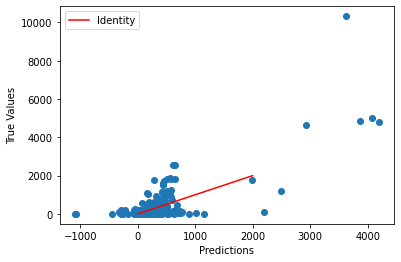

In [27]:
#Ploteamos Predictions vs True values del set polinomico
plt.scatter(poly_linear_prediction, ytest)
plt.plot(np.arange(0,2000),np.arange(0,2000), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {poly_linear_r2:.6f}')
print(f'MAE: {poly_linear_mae:.6f}')
print(f'MSE: {poly_linear_mse:.6f}')

R2 score: 0.556939
MAE: 427.036030
MSE: 590891.816208


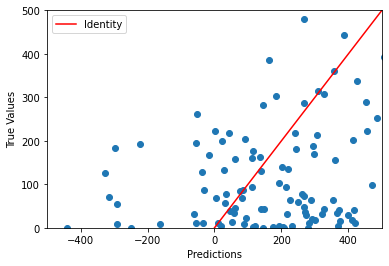

In [28]:
# Plot con 'zoom'
plt.scatter(poly_linear_prediction, ytest)
plt.plot(np.arange(0,500),np.arange(0,500), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.xlim((-500,500))
plt.ylim((0,500))
plt.legend()
print(f'R2 score: {poly_linear_r2:.6f}')
print(f'MAE: {poly_linear_mae:.6f}')
print(f'MSE: {poly_linear_mse:.6f}')

In [29]:
results_df = results_df.append({'Model':'Linear',
                                'Features':'Poly',
                                'Escalados': 'Si',
                                'R2':poly_linear_r2,
                                'MSE':poly_linear_mse,
                                'MAE':poly_linear_mae},ignore_index=True)

## Ridge Regression

Linear Features

In [30]:
est = Ridge()
# Lista del parametro lambda (llamado 'alpha' en el GridSearch )
lambdas = [170,175,176,177,178,179,180,181,182,183,184,185,190,200]
# Juntamos el diccionario de parametros
parameters = {'alpha': lambdas}
# Definimos nuevamente el objeto GS con los parametros previamente definidos
gs = GridSearchCV(est, param_grid=parameters,refit=True, cv=n_folds, scoring="neg_mean_squared_error")

In [31]:
# Entrenamos
gs.fit(xtrain_scal, ytrain)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [170, 175, 176, 177, 178, 179, 180, 181, 182,
                                   183, 184, 185, 190, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [32]:
# Mostramos el mejor estimador, sus hyperparametros seleccionados y su resultado
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

Ridge(alpha=170, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001) 

{'alpha': 170} 

-559071.5013978975 



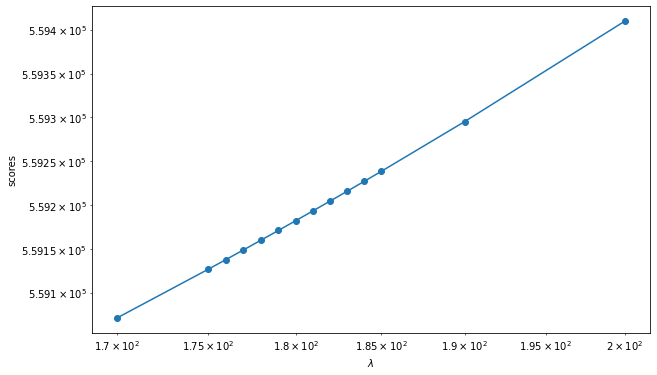

In [33]:
# Vamos a plotear nuestro parametro lambda vs. el score
fit_lambdas = [d['alpha'] for d in gs.cv_results_['params']]
fit_scores = gs.cv_results_['mean_test_score']
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(fit_lambdas, -fit_scores, ls='-', marker='o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('scores');

In [34]:
#Predicciones + Metricas
ridge_prediction = gs.best_estimator_.predict(xtest_scal)
ridge_r2 = r2_score(y_true=ytest, y_pred=ridge_prediction)
ridge_mse = mean_squared_error(y_true=ytest, y_pred=ridge_prediction)
ridge_mae = mean_absolute_error(y_true=ytest, y_pred=ridge_prediction)

R2 score: -0.004658
MAE: 530.081486
MSE: 1339871.270661


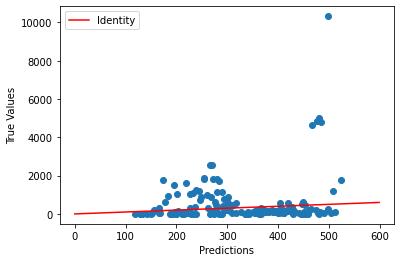

In [35]:
# Plots
plt.scatter(ridge_prediction, ytest)
plt.plot(np.arange(0,600),np.arange(0,600), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {ridge_r2:.6f}')
print(f'MAE: {ridge_mae:.6f}')
print(f'MSE: {ridge_mse:.6f}')

In [36]:
#Guardamos resultados
results_df = results_df.append({'Model':'Ridge',
                                'Features':'Lineal',
                                'Escalados': 'Si',
                                'R2':ridge_r2,
                                'MSE':ridge_mse,
                                'MAE':ridge_mae},ignore_index=True)

Polynomial Features

In [37]:
gs = GridSearchCV(est, param_grid=parameters,refit=True, cv=n_folds, scoring="neg_mean_squared_error")
gs.fit(xtrain_poly_scaled, ytrain)
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

Ridge(alpha=170, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001) 

{'alpha': 170} 

-349735.88260398473 



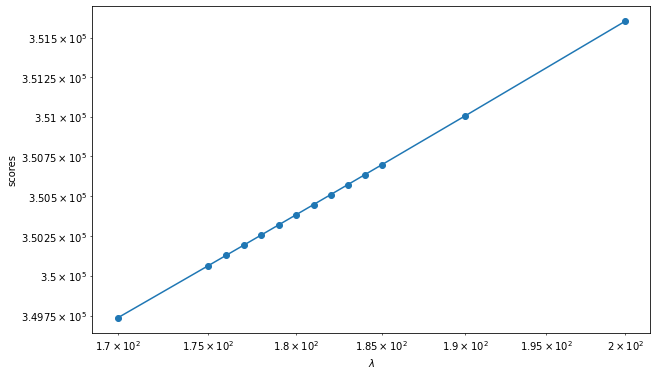

In [38]:
# Ploteamos nuestro parametro lambda vs el score
fit_lambdas = [d['alpha'] for d in gs.cv_results_['params']]
fit_scores = gs.cv_results_['mean_test_score']
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(fit_lambdas, -fit_scores, ls='-', marker='o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('scores');

In [39]:
# Prediccion + Metricas
poly_ridge_prediction = gs.best_estimator_.predict(xtest_poly_scaled)
poly_ridge_r2 = r2_score(y_true=ytest, y_pred=poly_ridge_prediction)
poly_ridge_mse = mean_squared_error(y_true=ytest, y_pred=poly_ridge_prediction)
poly_ridge_mae = mean_absolute_error(y_true=ytest, y_pred=poly_ridge_prediction)

R2 score: 0.439726
MAE: 439.818253
MSE: 747214.516794


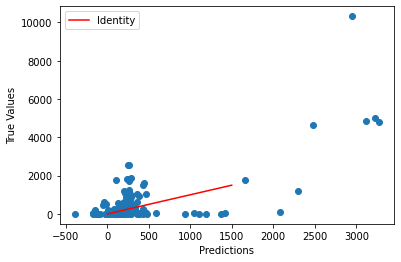

In [40]:
# Plots
plt.scatter(poly_ridge_prediction, ytest)
plt.plot(np.arange(0,1500),np.arange(0,1500), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {poly_ridge_r2:.6f}')
print(f'MAE: {poly_ridge_mae:.6f}')
print(f'MSE: {poly_ridge_mse:.6f}')

In [41]:
# Guardamos resultados
results_df = results_df.append({'Model':'Ridge',
                                'Features':'Poly',
                                'Escalados': 'Si',
                                'R2':poly_ridge_r2,
                                'MSE':poly_ridge_mse,
                                'MAE':poly_ridge_mae},ignore_index=True)

## Support Vector Regression

Linear Features

In [42]:
est = SVR(max_iter=25000)
# Lista del parametro lambda (parametro 'alpha')
parameters = {'C' : [1500,2000,2500,3000,3100,3200,3300],
              'epsilon' : [0.00001,0.00005,0.0001],
             'gamma':[30,40,50,60,70,80]}
# Definimos nuevamente el objeto GS con los parametros previamente definidos
gs = GridSearchCV(est, param_grid=parameters,refit=True,
                  cv=n_folds, scoring="neg_mean_squared_error",
                  verbose=3, n_jobs=3)

In [43]:
# Entrenamos
gs.fit(xtrain_scal, ytrain)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done 395 tasks      | elapsed:   10.4s
[Parallel(n_jobs=3)]: Done 625 out of 630 | elapsed:   15.5s remaining:    0.1s
[Parallel(n_jobs=3)]: Done 630 out of 630 | elapsed:   15.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=25000, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=3,
             param_grid={'C': [1500, 2000, 2500, 3000, 3100, 3200, 3300],
                         'epsilon': [1e-05, 5e-05, 0.0001],
                         'gamma': [30, 40, 50, 60, 70, 80]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=3)

In [44]:
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

SVR(C=3100, cache_size=200, coef0=0.0, degree=3, epsilon=5e-05, gamma=30,
    kernel='rbf', max_iter=25000, shrinking=True, tol=0.001, verbose=False) 

{'C': 3100, 'epsilon': 5e-05, 'gamma': 30} 

-447000.65429657325 



In [45]:
# Prediccion + Metricas
svr_prediction = gs.best_estimator_.predict(xtest_scal)
svr_r2 = r2_score(y_true=ytest, y_pred=svr_prediction)
svr_mse = mean_squared_error(y_true=ytest, y_pred=svr_prediction)
svr_mae = mean_absolute_error(y_true=ytest, y_pred=svr_prediction)

R2 score: 0.403522
MAE: 383.335673
MSE: 795498.127030


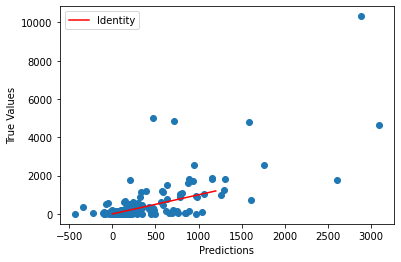

In [46]:
plt.scatter(svr_prediction, ytest)
plt.plot(np.arange(0,1200),np.arange(0,1200), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {svr_r2:.6f}')
print(f'MAE: {svr_mae:.6f}')
print(f'MSE: {svr_mse:.6f}')

In [47]:
results_df = results_df.append({'Model':'SVR',
                                'Features':'Linear',
                                'Escalados': 'Si',
                                'R2':svr_r2,
                                'MSE':svr_mse,
                                'MAE':svr_mae},ignore_index=True)

Polynomial Features

In [48]:
grad_poly = 4
xtrain_poly_scaled = PolynomialFeatures(grad_poly).fit_transform(xtrain_scal)
xtest_poly_scaled = PolynomialFeatures(grad_poly).fit_transform(xtest_scal)

In [49]:
est = SVR(kernel='rbf',max_iter=25000)
parameters = {'C' : [2700,2800,2900,3000,3500,4000],
              'epsilon' : [10,50,100,150,200,500,1000],
             'gamma':[0.01,0.05,0.1,0.5,1]}

gs = GridSearchCV(est, param_grid=parameters, cv=n_folds, scoring="neg_mean_squared_error",
                  n_jobs=5,verbose=3,refit=True)
gs.fit(xtrain_poly_scaled, ytrain)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 414 tasks      | elapsed:    7.4s
[Parallel(n_jobs=5)]: Done 1041 out of 1050 | elapsed:   16.3s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 1050 out of 1050 | elapsed:   16.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=25000, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=5,
             param_grid={'C': [2700, 2800, 2900, 3000, 3500, 4000],
                         'epsilon': [10, 50, 100, 150, 200, 500, 1000],
                         'gamma': [0.01, 0.05, 0.1, 0.5, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=3)

In [50]:
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

SVR(C=2700, cache_size=200, coef0=0.0, degree=3, epsilon=150, gamma=0.1,
    kernel='rbf', max_iter=25000, shrinking=True, tol=0.001, verbose=False) 

{'C': 2700, 'epsilon': 150, 'gamma': 0.1} 

-300539.34731699986 



In [51]:
# Prediccion + Metricas
poly_svr_prediction = gs.best_estimator_.predict(xtest_poly_scaled)
poly_svr_r2 = r2_score(y_true=ytest, y_pred=poly_svr_prediction)
poly_svr_mse = mean_squared_error(y_true=ytest, y_pred=poly_svr_prediction)
poly_svr_mae = mean_absolute_error(y_true=ytest, y_pred=poly_svr_prediction)

R2 score: 0.533768
MAE: 382.872746
MSE: 621794.873067


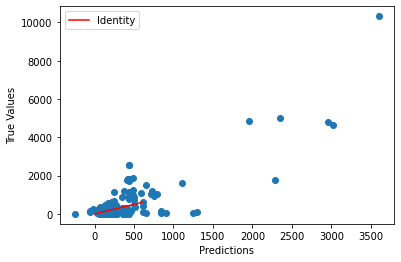

In [52]:
#Plot
plt.scatter(poly_svr_prediction, ytest)
plt.plot(np.arange(0,600),np.arange(0,600), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {poly_svr_r2:.6f}')
print(f'MAE: {poly_svr_mae:.6f}')
print(f'MSE: {poly_svr_mse:.6f}')

R2 score: 0.556939
MAE: 427.036030
MSE: 590891.816208


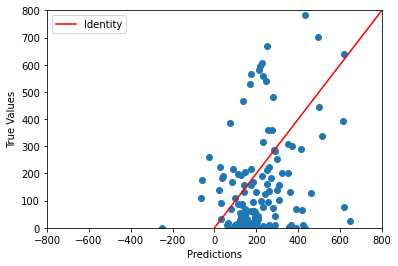

In [53]:
# Plot con 'zoom'
plt.scatter(poly_svr_prediction, ytest)
plt.plot(np.arange(0,800),np.arange(0,800), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.xlim((-800,800))
plt.ylim((0,800))
plt.legend()
print(f'R2 score: {poly_linear_r2:.6f}')
print(f'MAE: {poly_linear_mae:.6f}')
print(f'MSE: {poly_linear_mse:.6f}')

In [54]:
#Guardamos resultados
results_df = results_df.append({'Model':'SVR',
                                'Features':'Poly',
                                'Escalados': 'Si',
                                'R2':poly_svr_r2,
                                'MSE':poly_svr_mse,
                                'MAE':poly_svr_mae},ignore_index=True)

# KNN

Linear Features

In [55]:
knn = KNeighborsRegressor()
parameters_k = np.arange(20,31,5)
parameters_knn = [{'n_neighbors': parameters_k}]

In [56]:
gs = GridSearchCV(knn, param_grid=parameters_knn,refit=True,
                  cv=n_folds, scoring="neg_mean_squared_error",
                  verbose=3, n_jobs=3)

In [57]:
gs.fit(xtrain_scal, ytrain)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:    0.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=3,
             param_grid=[{'n_neighbors': array([20, 25, 30])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=3)

In [58]:
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                    weights='uniform') 

{'n_neighbors': 20} 

-486781.3291249999 



In [59]:
knn_prediction = gs.best_estimator_.predict(xtest_scal)
knn_r2 = r2_score(y_true=ytest, y_pred=knn_prediction)
knn_mse = mean_squared_error(y_true=ytest, y_pred=knn_prediction)
knn_mae = mean_absolute_error(y_true=ytest, y_pred=knn_prediction)

R2 score: 0.180811
MAE: 455.722866
MSE: 1092518.360046


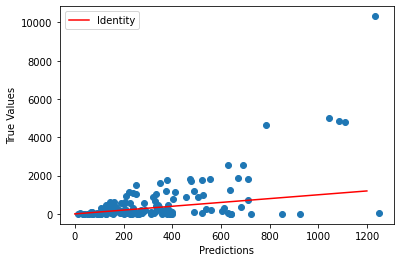

In [60]:
plt.scatter(knn_prediction, ytest)
plt.plot(np.arange(0,1200),np.arange(0,1200), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {knn_r2:.6f}')
print(f'MAE: {knn_mae:.6f}')
print(f'MSE: {knn_mse:.6f}')

In [61]:
results_df = results_df.append({'Model':'Knn',
                                'Features':'Linear',
                                'Escalados': 'Si',
                                'R2':knn_r2,
                                'MSE':knn_mse,
                                'MAE':knn_mae},ignore_index=True)

Polynomial Features

In [62]:
gs.fit(xtrain_poly_scaled, ytrain)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:    0.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=3,
             param_grid=[{'n_neighbors': array([20, 25, 30])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=3)

In [63]:
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                    weights='uniform') 

{'n_neighbors': 20} 

-436339.37329605257 



In [64]:
poly_knn_prediction = gs.best_estimator_.predict(xtest_poly_scaled)
poly_knn_r2 = r2_score(y_true=ytest, y_pred=knn_prediction)
poly_knn_mse = mean_squared_error(y_true=ytest, y_pred=knn_prediction)
poly_knn_mae = mean_absolute_error(y_true=ytest, y_pred=knn_prediction)

R2 score: 0.180811
MAE: 455.722866
MSE: 1092518.360046


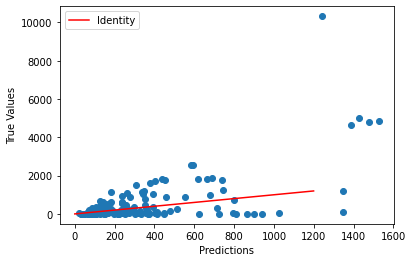

In [65]:
plt.scatter(poly_knn_prediction, ytest)
plt.plot(np.arange(0,1200),np.arange(0,1200), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {poly_knn_r2:.6f}')
print(f'MAE: {poly_knn_mae:.6f}')
print(f'MSE: {poly_knn_mse:.6f}')

In [66]:
#Guardamos resultados
results_df = results_df.append({'Model':'Knn',
                                'Features':'Poly',
                                'Escalados': 'Si',
                                'R2':knn_r2,
                                'MSE':knn_mse,
                                'MAE':knn_mae},ignore_index=True)

# Random Forest

Linear Features

In [67]:
est_rfr = RandomForestRegressor()
parameters_rfr = {'max_depth':[2,5,10],
                  'n_estimators':[100,50,10]}

gs_rfr = GridSearchCV(est_rfr, param_grid=parameters_rfr,refit=True,
                  scoring="neg_mean_squared_error",
                  verbose=3, n_jobs=3)

In [68]:
gs_rfr.fit(xtrain_scal, ytrain)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:    2.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [69]:
print(gs_rfr.best_estimator_, "\n")
print(gs_rfr.best_params_, "\n")
print(gs_rfr.best_score_, "\n")

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) 

{'max_depth': 10, 'n_estimators': 50} 

-219925.3484830428 



In [70]:
random_prediction = gs_rfr.best_estimator_.predict(xtest_scal)
random_r2 = r2_score(y_true=ytest, y_pred=random_prediction)
random_mse = mean_squared_error(y_true=ytest, y_pred=random_prediction)
random_mae = mean_absolute_error(y_true=ytest, y_pred=knn_prediction)

R2 score: 0.728068
MAE: 455.722866
MSE: 362664.096969


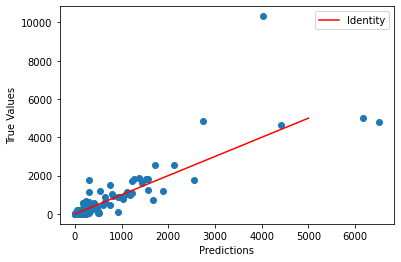

In [71]:
plt.scatter(random_prediction, ytest)
plt.plot(np.arange(0,5000),np.arange(0,5000), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {random_r2:.6f}')
print(f'MAE: {random_mae:.6f}')
print(f'MSE: {random_mse:.6f}')

In [72]:
results_df = results_df.append({'Model':'Random',
                                'Features':'Liner',
                                'Escalados': 'Si',
                                'R2':random_r2,
                                'MSE':random_mse,
                                'MAE':random_mae},ignore_index=True)

Polynomial Features

In [73]:
gs_rfr.fit(xtrain_poly_scaled, ytrain)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:    4.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [74]:
print(gs_rfr.best_estimator_, "\n")
print(gs_rfr.best_params_, "\n")
print(gs_rfr.best_score_, "\n")

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) 

{'max_depth': 10, 'n_estimators': 10} 

-210278.69338341322 



In [75]:
poly_random_prediction = gs_rfr.best_estimator_.predict(xtest_poly_scaled)
poly_random_r2 = r2_score(y_true=ytest, y_pred=poly_random_prediction)
poly_random_mse = mean_squared_error(y_true=ytest, y_pred=poly_random_prediction)
poly_random_mae = mean_absolute_error(y_true=ytest, y_pred=poly_random_prediction)

R2 score: 0.759793
MAE: 231.672937
MSE: 320353.927452


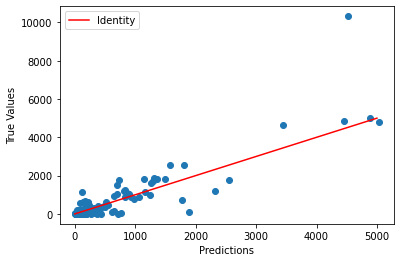

In [76]:
plt.scatter(poly_random_prediction, ytest)
plt.plot(np.arange(0,5000),np.arange(0,5000), 'r', label='Identity')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.legend()
print(f'R2 score: {poly_random_r2:.6f}')
print(f'MAE: {poly_random_mae:.6f}')
print(f'MSE: {poly_random_mse:.6f}')

In [77]:
results_df = results_df.append({'Model':'Random',
                                'Features':'Poly',
                                'Escalados': 'Si',
                                'R2':poly_random_r2,
                                'MSE':poly_random_mse,
                                'MAE':poly_random_mae},ignore_index=True)

## Resultados

In [78]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Para acotar los decimales en pandas
display(results_df)

,Model,Features,Escalados,R2,MSE,MAE
0,Linear,Lineal,No,0.000,1333570.637,534.978
1,Linear,Lineal,Si,0.000,1333570.637,534.978
2,Linear,Poly,Si,0.557,590891.816,427.036
3,Ridge,Lineal,Si,-0.005,1339871.271,530.081
4,Ridge,Poly,Si,0.440,747214.517,439.818
5,SVR,Linear,Si,0.404,795498.127,383.336
6,SVR,Poly,Si,0.534,621794.873,382.873
7,Knn,Linear,Si,0.181,1092518.360,455.723
8,Knn,Poly,Si,0.181,1092518.360,455.723
9,Random,Liner,Si,0.728,362664.097,455.723


Concluimos que la mejor estimación fue obtenida al emplear el Modelo de Random Forest Regression